# Bitcoin Price Prediction

## The Domain

The goal is to predict bitcoin prices, based on previously recorded prices.

Although a precise prediction is desirable, predicting general trends is acceptable.

## Data Wrangling

### Exploratory Data Analysis

#### loading the data

Source: https://blockchain.info/charts/market-price?timespan=all

Downloaded on Feb 2, 2018

In [201]:
import pandas as pd
df = pd.read_csv('datasets/all_time.csv')
df.columns = ['DATE', 'PRICE']
df.tail()

,DATE,PRICE
1652,2018-01-22 00:00:00,10544.593333
1653,2018-01-24 00:00:00,11282.258333
1654,2018-01-26 00:00:00,10969.815000
1655,2018-01-28 00:00:00,11765.710000
1656,2018-01-30 00:00:00,10184.061667


There are not a lot of datapoints in this dataset, as you can see there is only a datapoint every other day.

#### visualizing the data

There is a massive spike in december 2017 visible. The irregular tendencies of the data make it probably very hard to train a good model that is not overfitting the training set. This is only guessing at this point tho.

The other thing we know is that the data is a time series. Meaning: it is a series of data points indexed in time order. This will play a large role in what kind of model we can use for prediction.

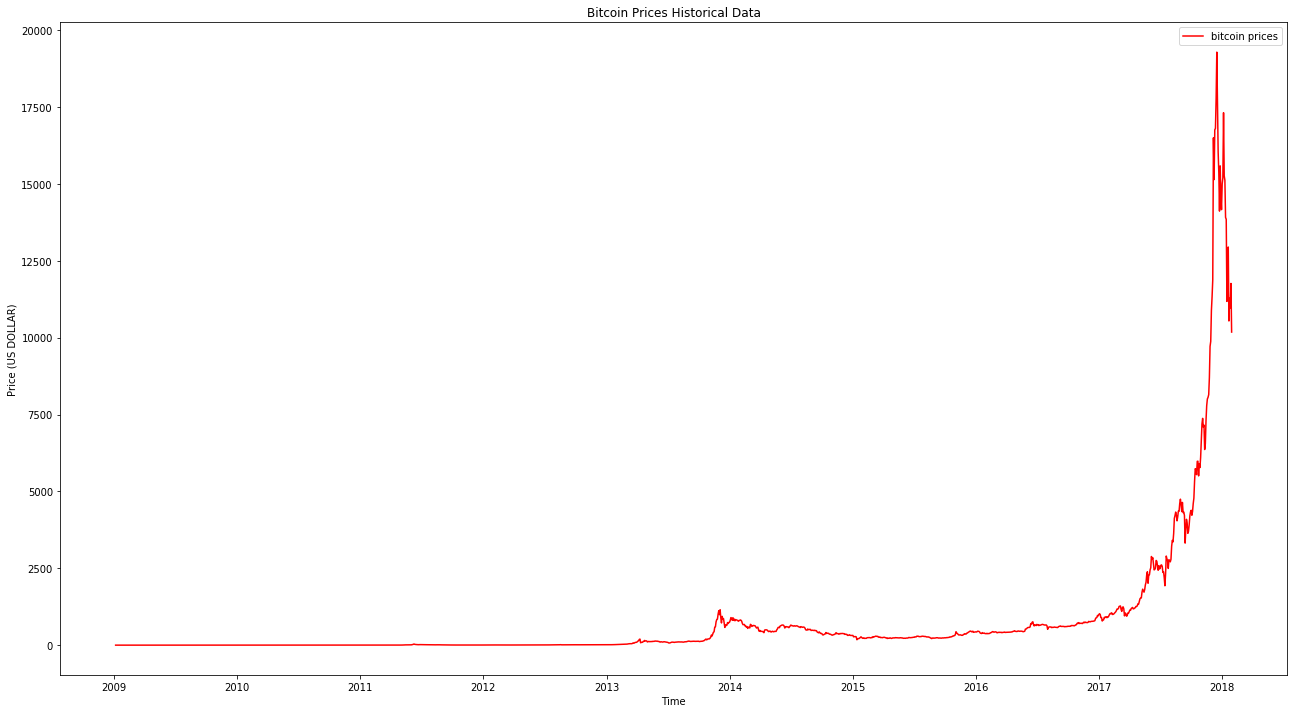

In [203]:
import matplotlib.pyplot as plt
import datetime as dt

# creating timestamps for the x axis
df_dates = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in df.DATE]

plt.figure(figsize=(22,12))
plt.plot(df_dates, df.PRICE, color='red', label='bitcoin prices')
plt.title('Bitcoin Prices Historical Data')
plt.ylabel('Price (US DOLLAR)')
plt.xlabel('Time')
plt.legend()
plt.show()

## Model: LSTM

### Why?

### What are LSTMs?

### Train

### Test

### Measure

## load the data

Source: https://blockchain.info/charts/market-price?timespan=all

Downloaded on Feb 2, 2018

In [173]:
import pandas as pd
df = pd.read_csv('datasets/all_time.csv')
df.columns = ['DATE', 'PRICE']
df.tail()

,DATE,PRICE
1652,2018-01-22 00:00:00,10544.593333
1653,2018-01-24 00:00:00,11282.258333
1654,2018-01-26 00:00:00,10969.815000
1655,2018-01-28 00:00:00,11765.710000
1656,2018-01-30 00:00:00,10184.061667


Not all that many data points. We will very likely achieve far better prediction results with a more granular data set

In [174]:
df.shape

(1657, 2)

## visualizing the data

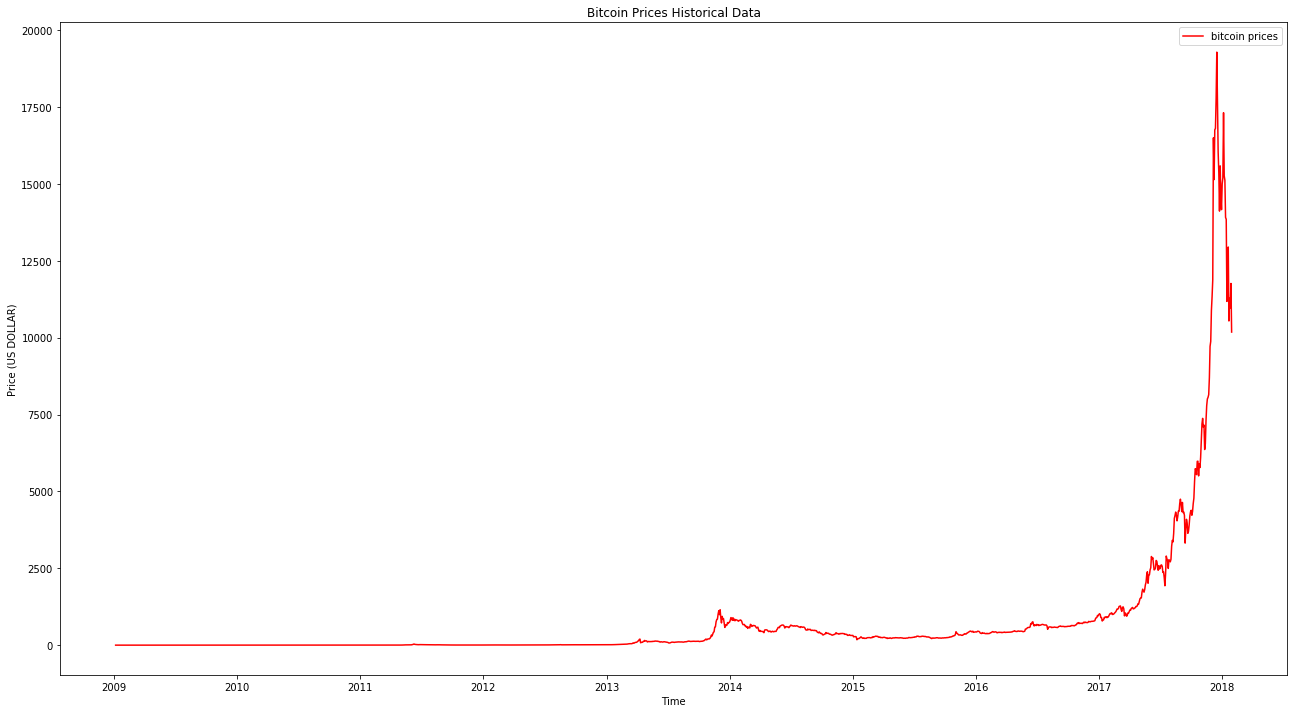

In [175]:
import matplotlib.pyplot as plt
import datetime as dt

df_dates = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in df.DATE]
plt.figure(figsize=(22,12))
plt.plot(df_dates, df.PRICE, color='red', label='bitcoin prices')
plt.title('Bitcoin Prices Historical Data')
plt.ylabel('Price (US DOLLAR)')
plt.xlabel('Time')
plt.legend()
plt.show()

## Stateful LSTM

## Batch size

In [176]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

### batch size and training set size

with stateful LSTMs the training set size must be divisible without a remainder by the batch size (modulo 0)

In [177]:
# defining the batch size and number of epochs
batch_size = 64 # showing 64 data points to the nn per iteration, every batch_size n the weights are updated
epochs = 120    # how often does the nn see each data point
timesteps = 30  # lstm: aware of the sequence - show 30 timesteps to predict 30 timesteps

In [178]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo = x % batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return(max(train_length_values))

In [179]:
def get_test_length(dataset, batch_size, upper_train):   
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps * 2): 
        modulo = (x - upper_train) % batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return(max(test_length_values))

In [180]:
length = len(df)
print(length)
length *= 1 - 0.2 # length of the training set, assuming test-set is 0.1% of the data set
print(length)

1657
1325.6000000000001


In [181]:
print(length % batch_size) # not divisible by batch size without a remainder
print(1472 % batch_size)

45.600000000000136
0


In [182]:
length = get_train_length(df, batch_size, 0.3)

1088
1152


#### training set

In [183]:
# Adding timesteps * 2

upper_train = length + timesteps * 2
df_train = df[0:upper_train]
training_set = df_train.iloc[:,1:2].values
training_set.shape

(1212, 1)

In [184]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(1212, 1)

In [185]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps):
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))

1182
1152
1152


In [186]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(1152, 30, 1)
(1152, 30, 1)


## Training the neural network

In [187]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [188]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_7 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_8 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_4 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


### Parameters

PARAMETERS = 4 × LSTM outputs size × (weights LSTM inputs size + weights LSTM outputs size + 1 bias variable)

In [189]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [190]:
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [191]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
1152/1152 [==============================] - 2s 1ms/step - loss: 0.1038
Epoch: 1
Epoch 1/1
1152/1152 [==============================] - 0s 409us/step - loss: 0.1106
Epoch: 2
Epoch 1/1
1152/1152 [==============================] - 0s 409us/step - loss: 0.0902
Epoch: 3
Epoch 1/1
1152/1152 [==============================] - 0s 404us/step - loss: 0.0486
Epoch: 4
Epoch 1/1
1152/1152 [==============================] - 0s 404us/step - loss: 0.0596
Epoch: 5
Epoch 1/1
1152/1152 [==============================] - 0s 391us/step - loss: 0.0505
Epoch: 6
Epoch 1/1
1152/1152 [==============================] - 0s 408us/step - loss: 0.0468
Epoch: 7
Epoch 1/1
1152/1152 [==============================] - 0s 399us/step - loss: 0.0621
Epoch: 8
Epoch 1/1
1152/1152 [==============================] - 0s 406us/step - loss: 0.0449
Epoch: 9
Epoch 1/1
1152/1152 [==============================] - 0s 412us/step - loss: 0.0564
Epoch: 10
Epoch 1/1
1152/1152 [==============================] - 0s 402u

1152/1152 [==============================] - 0s 424us/step - loss: 0.0393
Epoch: 88
Epoch 1/1
1152/1152 [==============================] - 0s 395us/step - loss: 0.0393
Epoch: 89
Epoch 1/1
1152/1152 [==============================] - 0s 393us/step - loss: 0.0391
Epoch: 90
Epoch 1/1
1152/1152 [==============================] - 0s 404us/step - loss: 0.0390
Epoch: 91
Epoch 1/1
1152/1152 [==============================] - 0s 394us/step - loss: 0.0394
Epoch: 92
Epoch 1/1
1152/1152 [==============================] - 0s 392us/step - loss: 0.0396
Epoch: 93
Epoch 1/1
1152/1152 [==============================] - 0s 403us/step - loss: 0.0444
Epoch: 94
Epoch 1/1
1152/1152 [==============================] - 0s 400us/step - loss: 0.0464
Epoch: 95
Epoch 1/1
1152/1152 [==============================] - 0s 403us/step - loss: 0.0443
Epoch: 96
Epoch 1/1
1152/1152 [==============================] - 0s 407us/step - loss: 0.0425
Epoch: 97
Epoch 1/1
1152/1152 [==============================] - 0s 397us/step -

In [192]:
!pwd
!ls models/*.h5

/Users/oem/Dropbox/lab/ml/bootcamp_berlin/bitcoin-prediction
ls: models/*.h5: No such file or directory


## Validation

In [193]:
test_length = get_test_length(df, batch_size, upper_train)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

1468
1532
1596
1596
384


In [194]:
print(upper_train, upper_test, len(df))

1212 1656 1657


In [195]:
# construct test set

#subsetting
df_test = df[upper_train:upper_test] 
test_set = df_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [196]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(384, 30, 1)
(384, 30)
(354, 1)


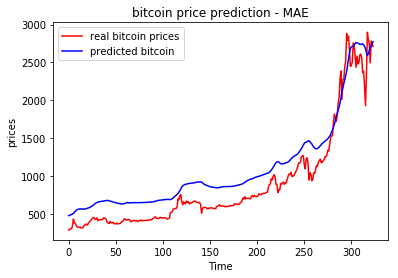

In [197]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'real bitcoin prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'predicted bitcoin')
plt.title('bitcoin price prediction - MAE')
plt.xlabel('Time')
plt.ylabel('prices')
plt.legend()
plt.show()

In [198]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

242.6933425195454


In [199]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

229.187034877
